In [4]:
!pip install pandas numpy scikit-surprise scikit-learn matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505164 sha256=bdeb7c59e54db96887654f770e5006f5e6e30efe8ab93d0c4beff6a5f7003976
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load MovieLens dataset
movies = pd.read_csv("https://files.grouplens.org/datasets/movielens/ml-100k/u.item", sep="|", encoding="latin-1", usecols=[0, 1], names=["MovieID", "Title"])
ratings = pd.read_csv("https://files.grouplens.org/datasets/movielens/ml-100k/u.data", sep="\t", names=["UserID", "MovieID", "Rating", "Timestamp"])

# Merge Datasets
data = pd.merge(ratings, movies, on="MovieID")
data.drop(columns=["Timestamp"], inplace=True)

# Display first 5 rows
data.tail()

,UserID,MovieID,Rating,Title
99995,880,476,3,"First Wives Club, The (1996)"
99996,716,204,5,Back to the Future (1985)
99997,276,1090,1,Sliver (1993)
99998,13,225,2,101 Dalmatians (1996)
99999,12,203,3,Unforgiven (1992)


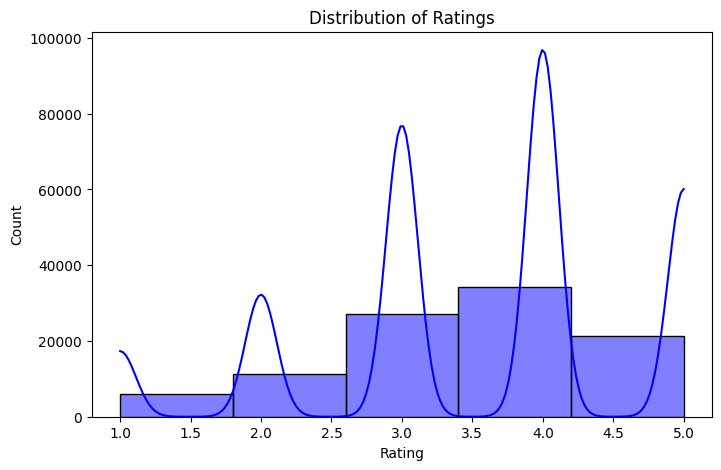

<ipython-input-2-1bce8ab85f5b>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_movies.values, y=top_movies.index, palette="coolwarm")


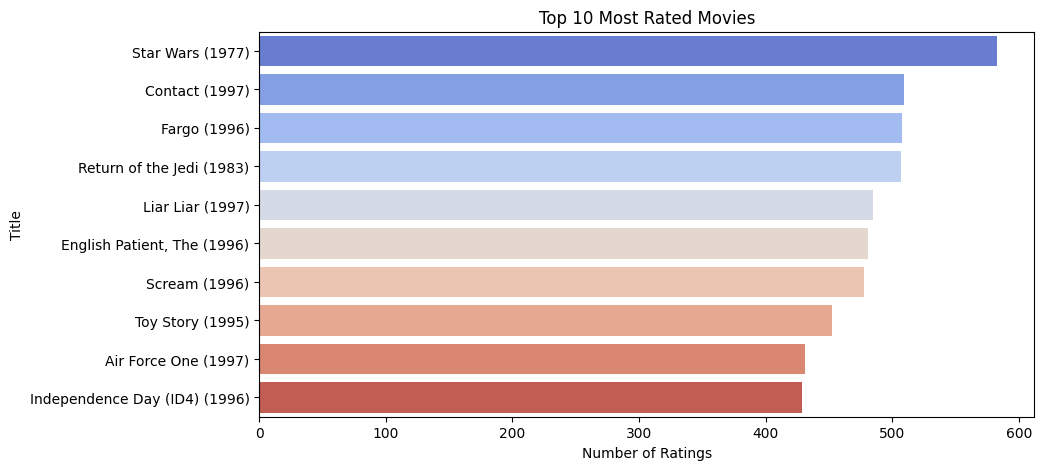

In [2]:
# Ratings Distribution
plt.figure(figsize=(8, 5))
sns.histplot(data["Rating"], bins=5, kde=True, color="blue")
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# Top 10 Most Rated Movies
top_movies = data.groupby("Title")["Rating"].count().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_movies.values, y=top_movies.index, palette="coolwarm")
plt.title("Top 10 Most Rated Movies")
plt.xlabel("Number of Ratings")
plt.show()

In [5]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, GridSearchCV
from surprise import accuracy

# Load Data into Surprise
reader = Reader(rating_scale=(1, 5))
dataset = Dataset.load_from_df(data[["UserID", "MovieID", "Rating"]], reader)

# Split Data into Train & Test Sets
trainset, testset = train_test_split(dataset, test_size=0.2, random_state=42)

In [6]:
# Define Hyperparameter Grid
param_grid = {"n_factors": [50, 100, 150], "reg_all": [0.02, 0.05, 0.1]}

# Perform Grid Search
grid_search = GridSearchCV(SVD, param_grid, measures=["rmse"], cv=3)
grid_search.fit(dataset)

# Get Best Parameters
best_params = grid_search.best_params["rmse"]
print("Best Parameters:", best_params)

# Train Best SVD Model
model = SVD(n_factors=best_params["n_factors"], reg_all=best_params["reg_all"])
model.fit(trainset)

# Evaluate Model
predictions = model.test(testset)
print("Best RMSE:", accuracy.rmse(predictions))

Best Parameters: {'n_factors': 50, 'reg_all': 0.05}
RMSE: 0.9339
Best RMSE: 0.9338971163665186


In [7]:
def get_movie_recommendations(user_id, model, movies_df, n):
    """Recommends top N movies for a given user"""

    movie_ids = movies_df["MovieID"].unique()

    # Predict ratings for all movies
    predictions = [model.predict(user_id, mid) for mid in movie_ids]

    # Sort by highest predicted rating
    predictions.sort(key=lambda x: x.est, reverse=True)

    # Get top N recommended movies
    top_movies = [movies_df[movies_df["MovieID"] == pred.iid]["Title"].values[0] for pred in predictions[:n]]

    return top_movies

# Example: Recommend n movies for User ID
id=int(input("Enter User ID: "))
n=int(input("Enter Number of Movies: "))
recommended_movies = get_movie_recommendations(id, model, movies,n)
print("Recommended Movies:", recommended_movies)

Enter User ID: 5
Enter Number of Movies: 10
Recommended Movies: ['Usual Suspects, The (1995)', 'Star Wars (1977)', 'Close Shave, A (1995)', 'Wrong Trousers, The (1993)', 'Raiders of the Lost Ark (1981)', 'Shawshank Redemption, The (1994)', 'Wallace & Gromit: The Best of Aardman Animation (1996)', 'Citizen Kane (1941)', 'Empire Strikes Back, The (1980)', 'Casablanca (1942)']
